This notebook will make decision tree models to analyze RIPA data set. 

In [1]:
#import libraries
import pandas as pd 
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score

In [2]:
#import data
%store -r train_data 
%store -r test_data 
%store -r train_target 
%store -r test_target 

Lets first see a basic decision tree and see how it performs. 

In [3]:
tree_clf = DecisionTreeClassifier(max_depth = 20) # we set max depth to 20 because there are 20 features

tree_clf.fit(train_data, train_target)

DecisionTreeClassifier(max_depth=20)

In [4]:
#lets see the accuracy of this basic decision tree classifier 
basic_y_prediction = tree_clf.predict(test_data)

print(accuracy_score(test_target, basic_y_prediction))
#so our basic decision tree has an accuracy of 52.8%

0.528672583081571


Now lets print out a textual representation of the tree.

In [5]:
from sklearn import tree

text_representation_tree_1 = tree.export_text(tree_clf)
print(text_representation_tree_1)


|--- feature_16 <= 6.50
|   |--- feature_3 <= 49.50
|   |   |--- feature_19 <= 0.50
|   |   |   |--- feature_7 <= 124.50
|   |   |   |   |--- feature_3 <= 5.50
|   |   |   |   |   |--- feature_3 <= 4.50
|   |   |   |   |   |   |--- feature_0 <= 2.50
|   |   |   |   |   |   |   |--- feature_17 <= 10.50
|   |   |   |   |   |   |   |   |--- feature_11 <= 27.50
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |--- feature_11 >  27.50
|   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |--- feature_17 >  10.50
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |--- feature_0 >  2.50
|   |   |   |   |   |   |   |--- feature_2 <= 18.00
|   |   |   |   |   |   |   |   |--- feature_0 <= 23.50
|   |   |   |   |   |   |   |   |   |--- feature_2 <= 12.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- feature_2 >  12.50
|   |   |   |   |   |   |   |   |   |   |--- class: 2
|

In [6]:
#from matplotlib import pyplot as plt

#tree.plot_tree(tree_clf)

Now after assessing the basic decision tree, lets see how the random forests model compares.

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
#this random forest model serves as our base random forest model. We will compare all other models to this one.
rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = 1, random_state = 42)
rnd_clf.fit(train_data, train_target)

y_pred_rf = rnd_clf.predict(test_data)

In [9]:
#get accuracy score
print(accuracy_score(test_target, y_pred_rf))

0.4657760574018127


Our first, the base, random forest model has performed worse than the basic decision tree model with an accuracy score of 46%

Let's first see what this base random forest model deems as importance features. 

In [10]:
%store -r model_datalist

In [11]:
print(model_datalist)

['exp_years', 'date_stop', 'time_stop', 'stopduration', 'stop_in_response_to_cfs', 'officer_assignment_key', 'isschool', 'beat', 'pid', 'isstudent', 'perceived_limited_english', 'perceived_age', 'gender_nonconforming', 'gend', 'lgbt_cat', 'race_cat', 'stop_cat', 'action_cat', 'consented_cat', 'contraband_cat']


In [12]:
#feature importance 

for name, score in zip(model_datalist,
rnd_clf.feature_importances_):
    print(name, score)

exp_years 0.13561758157532056
date_stop 0.00013549159212030646
time_stop 0.011854136090103249
stopduration 0.22172270168950442
stop_in_response_to_cfs 0.028616464918355095
officer_assignment_key 0.011340717459263893
isschool 0.0
beat 0.02878946190623842
pid 0.036922385075106826
isstudent 0.0
perceived_limited_english 0.0
perceived_age 0.0033696617187430624
gender_nonconforming 0.0
gend 0.001960360039628561
lgbt_cat 3.159499551379464e-05
race_cat 0.0019353675395097866
stop_cat 0.36346768832581205
action_cat 0.1033135759334172
consented_cat 0.00037377242874561206
contraband_cat 0.05054903871261721


In [13]:
#lets get this list in descending order

importances = rnd_clf.feature_importances_

sorted_indices = np.argsort(importances)[::-1]

sorted_indices

array([16,  3,  0, 17, 19,  8,  7,  4,  2,  5, 11, 13, 15, 18,  1, 14, 12,
       10,  6,  9])

In [14]:
#lets get top five features: 16, 3, 0, 17, 19

top_five_features = list(model_datalist[i] for i in [16, 3, 0, 17, 19])
top_five_features

['stop_cat', 'stopduration', 'exp_years', 'action_cat', 'contraband_cat']

Top five features according to our base random forest model are stop category, stop duration, officer years of experience, action category, and whether there was contraband.

Now we will tune the hyperparameters. We will use a random search cross validation method. 

First, we will make a base Random Forest Classifier which we will then tune. We stuck with the same number of estimators as our first Random Forest Classifier. 

In [15]:
rfc = RandomForestClassifier(n_estimators = 500, random_state=42)

Now we will make a grid of hyperparameter options to conduct the search on.

In [16]:
#create a grid for hyperparameters

#number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 0, stop = 1000, num =10)]

#number of features to consider
max_features = ['auto', 'log2']

#maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10,110, num = 11)]
max_depth.append(None)

#minimum number of samples to split a node
min_samples_split = [2, 4, 10]

#minimum number of samples at each leaf node
min_samples_leaf = [1, 2, 4]



#create a grid 
grid = {
    #'n_estimators': n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf
}

For hyperparameter tuning we will use Scikit-Learns HalvingRandomSearchCV which is from SciKit-Learn experimental library but results in faster hypertuning. We care about computation speed due to the number of features in the model. More about this can be read here: https://towardsdatascience.com/11-times-faster-hyperparameter-tuning-with-halvinggridsearch-232ed0160155

In [17]:
#now run the grid search 
    #we will use scikit-learn HalvingRandomSearchCV which is experimental but faster

#import statements
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import cross_val_score


In [18]:
#now conducting the Halving Random Search CV
    #CV is automatically set to stratified k fold because the target variable Y is multiclass. 
search_rfc = HalvingRandomSearchCV(rfc, param_distributions = grid, 
                           random_state = 42, n_jobs=-1,
                                   n_candidates = "exhaust",
                                   factor=4
                                  ) #use default 5 fold cross validation

search_rfc.fit(train_data, train_target)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 216 is smaller than n_iter=3259. Running 216 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


HalvingRandomSearchCV(estimator=RandomForestClassifier(n_estimators=500,
                                                       random_state=42),
                      factor=4, n_jobs=-1,
                      param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         None],
                                           'max_features': ['auto', 'log2'],
                                           'min_samples_leaf': [1, 2, 4],
                                           'min_samples_split': [2, 4, 10]},
                      random_state=42,
                      refit=<function _refit_callable at 0x7fa781f4a8b0>)

In [19]:
#lets get the score and best parameters 
print(search_rfc.best_score_) #mean cross validated score of the best estimator
print(search_rfc.best_params_) #parameters that gave best results

0.5045673076923076
{'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20}


In [20]:
#get accuracy score 

y_prediction = search_rfc.predict(test_data)

print(accuracy_score(test_target, y_prediction))

0.5607345166163142


So our tuned Random Forest model performed better with an accuracy score of 56%. 

Let's see where our tuned Random Forest performed well and poorly. We will look at a confusion matrix and a classification report to check. 

In [21]:
#lets add a confusion matrix to see where it is underperforming
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(test_target, y_prediction)

array([[ 2414,  2849,  1362,    44,    55,   528,  6495,    14,     3,
          304,     0,     0,     0],
       [  745,  8434,  5070,   144,     8,   223,  4782,     1,     0,
           71,     0,     0,     0],
       [  108,  2106, 20450,   176,     8,   314,  2675,    14,     0,
           48,     0,     0,     0],
       [   45,   176,  1924,  1374,    15,   745,  1090,     3,     2,
          125,     0,     0,     0],
       [   66,    63,    91,   107,   779,  1501,   752,     0,     0,
          204,     0,     0,     0],
       [  119,    57,   219,   278,   206,  6431,  1496,    72,     5,
          667,     0,     0,     0],
       [  836,  1068,   974,   128,    61,   791, 17093,    15,     1,
          251,     0,     0,     0],
       [   64,    10,    54,    18,    11,   509,   547,   283,     1,
          329,     0,     0,     0],
       [   20,     6,     4,     0,     1,    43,    62,     2,    36,
           84,     0,     0,     0],
       [  142,     2,    12,

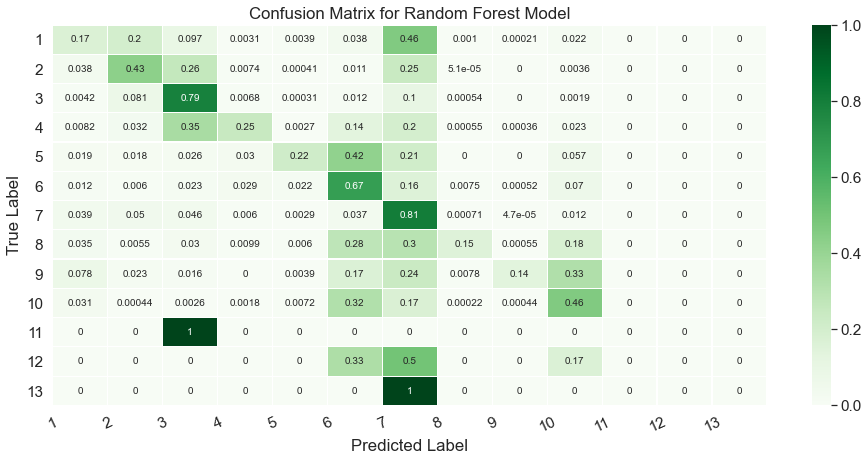

In [22]:
#try to plot a heat map for the confusion matrix 

import seaborn as sns 
import matplotlib.pyplot as plt

matrix = confusion_matrix(test_target, y_prediction)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

#plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
           cmap=plt.cm.Greens, linewidths=0.2)

#add labels to plot

class_names = [1,2,3,4,5,6,7,8,9,10,11,12,13] #all possible resultkeys

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5

plt.xticks(tick_marks, class_names, rotation = 25)
plt.yticks(tick_marks2, class_names, rotation = 0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.title('Confusion Matrix for Random Forest Model')
plt.show()

We see in this heatmap that the Random Forest did not perform that well in the diagonal, where one would expect it to. That is, the Random Forest is having a hard time correctly labeling outcomes. Elsewhere on the matrix, the Random Forest is being very cautious. 

In [23]:
#classification report

print(classification_report(test_target, y_prediction))

              precision    recall  f1-score   support

           1       0.53      0.17      0.26     14068
           2       0.57      0.43      0.49     19478
           3       0.68      0.79      0.73     25899
           4       0.60      0.25      0.35      5499
           5       0.66      0.22      0.33      3563
           6       0.51      0.67      0.58      9550
           7       0.48      0.81      0.60     21218
           8       0.70      0.15      0.25      1826
           9       0.72      0.14      0.23       258
          10       0.50      0.46      0.48      4552
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         1

    accuracy                           0.56    105920
   macro avg       0.46      0.32      0.33    105920
weighted avg       0.57      0.56      0.53    105920



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Since precision is high for many classes (target outcomes) yet recall is low, this tells us that our model is being too careful in labeling the correct outcomes.

We will now train a random forest using only the features deemed important above by the feature importance. We aim to improve the performance of the model by limiting the number of features 

In [24]:
top_five_features

['stop_cat', 'stopduration', 'exp_years', 'action_cat', 'contraband_cat']

In [25]:
%store -r model_data

In [26]:
model_data.columns

Index(['exp_years', 'date_stop', 'time_stop', 'stopduration',
       'stop_in_response_to_cfs', 'officer_assignment_key', 'isschool', 'beat',
       'pid', 'isstudent', 'perceived_limited_english', 'perceived_age',
       'gender_nonconforming', 'gend', 'resultkey', 'lgbt_cat', 'race_cat',
       'stop_cat', 'action_cat', 'consented_cat', 'contraband_cat'],
      dtype='object')

In [27]:
#lets grab only the columns we want 

select_data = model_data[np.intersect1d(model_data.columns, top_five_features)]

print(select_data)

        action_cat  contraband_cat  exp_years  stop_cat  stopduration
0               14               7         10         6            30
1               14               7         18         7            10
2                7               7          1         6            15
3                7               7          1         6            15
4               14               7          3         7             5
...            ...             ...        ...       ...           ...
529595          12               7          1         6           120
529596          12               7          1         6           180
529597          14               7          1         6            20
529598          14               7          1         6            20
529599          15               0         15         6           120

[529600 rows x 5 columns]


In [28]:
#import target data

%store -r target

In [29]:
#now split data
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(select_data, target,
                                                   test_size = 0.2, 
                                                   random_state = 42,
                                                   stratify = target)

#see if strafiying preserved the balance
from collections import Counter
print(Counter(target))
print(Counter(train_target))
print(Counter(test_target))

Counter({3: 129497, 7: 106090, 2: 97391, 1: 70342, 6: 47748, 4: 27495, 10: 22759, 5: 17813, 8: 9128, 9: 1291, 12: 29, 11: 11, 13: 6})
Counter({3: 103598, 7: 84872, 2: 77913, 1: 56274, 6: 38198, 4: 21996, 10: 18207, 5: 14250, 8: 7302, 9: 1033, 12: 23, 11: 9, 13: 5})
Counter({3: 25899, 7: 21218, 2: 19478, 1: 14068, 6: 9550, 4: 5499, 10: 4552, 5: 3563, 8: 1826, 9: 258, 12: 6, 11: 2, 13: 1})


In [30]:
print('Training Data Shape:', X_train.shape)
print('Training Labels Shape:', Y_train.shape)
print('Testing Data Shape:', X_test.shape)
print('Testing Labels Shape:', Y_test.shape)

Training Data Shape: (423680, 5)
Training Labels Shape: (423680,)
Testing Data Shape: (105920, 5)
Testing Labels Shape: (105920,)


Now we will train the random forest models. First the basic random forest model, which we will then tune the hyperparameters

In [31]:
refined_rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = 1, random_state = 42)
refined_rnd_clf.fit(X_train, Y_train)

y_pred_refined_rf = refined_rnd_clf.predict(X_test)

In [32]:
#get accuracy score 
refined_tree_acc = accuracy_score(Y_test, y_pred_refined_rf)
print(refined_tree_acc)

0.45890294561933537


Our basic random forest model trained on limited features performed worse!

Now we will hypertune the hyperparameters of this random forest model 

In [33]:
forest = RandomForestClassifier(n_estimators = 500, random_state=42)

As before we use Scikit Learns Halving Random Search CV to conduct the randomized search for hyper parameters.

In [34]:
search_forest = HalvingRandomSearchCV(forest, param_distributions = grid, 
                           random_state = 42, n_jobs=-1,
                                   n_candidates = "exhaust",
                                   factor=4
                                  )

search_forest.fit(X_train, Y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 216 is smaller than n_iter=3259. Running 216 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


HalvingRandomSearchCV(estimator=RandomForestClassifier(n_estimators=500,
                                                       random_state=42),
                      factor=4, n_jobs=-1,
                      param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         None],
                                           'max_features': ['auto', 'log2'],
                                           'min_samples_leaf': [1, 2, 4],
                                           'min_samples_split': [2, 4, 10]},
                      random_state=42,
                      refit=<function _refit_callable at 0x7fa781f4a8b0>)

In [35]:
#get accuracy score 

refined_forest_y_prediction = search_forest.predict(X_test)

print(accuracy_score(Y_test, refined_forest_y_prediction))

0.4934667673716012


This random forest model did worse, even with tuned hyper parameters.

We will once again look at the confusion matrix and classification report to see where this tuned Random Forest model is failing.

In [36]:
#lets add a confusion matrix to see where it is underperforming
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(Y_test, refined_forest_y_prediction)

array([[  502,  2469,  2091,    48,    58,   572,  7955,     7,     0,
          366,     0,     0,     0],
       [  184,  6819,  6319,   105,     4,   271,  5672,     1,     0,
          103,     0,     0,     0],
       [   47,  2261, 19188,   175,     4,   273,  3870,     0,     0,
           81,     0,     0,     0],
       [    3,   146,  2477,   724,    11,   684,  1305,     1,     0,
          148,     0,     0,     0],
       [   23,    53,    71,   146,   653,  1364,   899,     3,     0,
          351,     0,     0,     0],
       [   16,    44,   182,   412,   189,  5670,  2129,    29,     0,
          879,     0,     0,     0],
       [  197,   771,  1646,   184,    56,   952, 16973,     6,     0,
          433,     0,     0,     0],
       [   16,     8,    36,    21,    10,   445,   942,    69,     0,
          279,     0,     0,     0],
       [    1,     2,    10,    10,     4,    94,    89,     0,     0,
           48,     0,     0,     0],
       [   14,     1,    14,

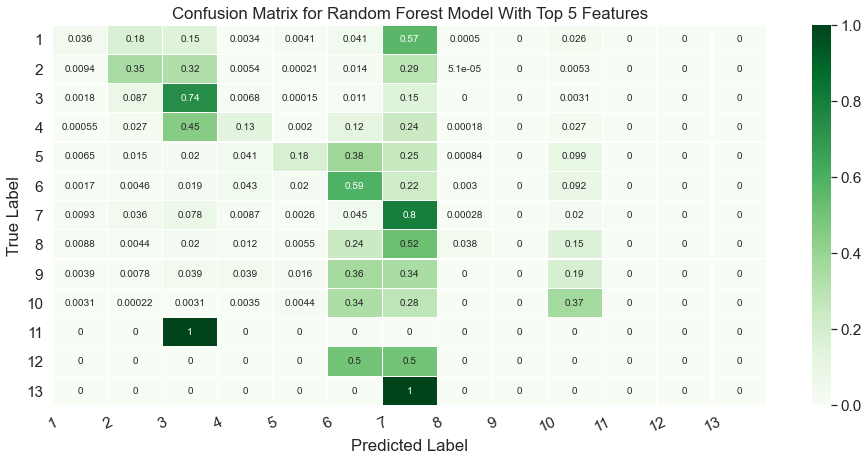

In [37]:
#lets create a graph
import seaborn as sns 
import matplotlib.pyplot as plt

matrix = confusion_matrix(Y_test, refined_forest_y_prediction)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

#plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
           cmap=plt.cm.Greens, linewidths=0.2)

#add labels to plot

class_names = [1,2,3,4,5,6,7,8,9,10,11,12,13] #all possible resultkeys

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5

plt.xticks(tick_marks, class_names, rotation = 25)
plt.yticks(tick_marks2, class_names, rotation = 0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.title('Confusion Matrix for Random Forest Model With Top 5 Features')
plt.show()

The confusion matrix shows us that this Random Forest model, trained on a select number of features, is performing worse. The diagonal shows us that the model is less likely to label correct outcomes.

In [38]:
print(classification_report(Y_test, refined_forest_y_prediction))

              precision    recall  f1-score   support

           1       0.50      0.04      0.07     14068
           2       0.54      0.35      0.43     19478
           3       0.60      0.74      0.66     25899
           4       0.39      0.13      0.20      5499
           5       0.65      0.18      0.29      3563
           6       0.48      0.59      0.53      9550
           7       0.41      0.80      0.54     21218
           8       0.59      0.04      0.07      1826
           9       0.00      0.00      0.00       258
          10       0.38      0.37      0.37      4552
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         1

    accuracy                           0.49    105920
   macro avg       0.35      0.25      0.24    105920
weighted avg       0.51      0.49      0.44    105920



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


If we compare this classification report with the previous classification report that is built from the random forests model using all features, we see that both precision and recall are worse. 

Now we will try to create EXtra Random Trees Model

In [39]:
#import statement

from sklearn.ensemble import ExtraTreesClassifier

#fit model

extra_trees_clf = ExtraTreesClassifier(random_state = 42)
extra_trees_clf.fit(train_data, train_target)

ExtraTreesClassifier(random_state=42)

In [40]:
#predict and get accuracy scrore
extra_trees_prediction = extra_trees_clf.predict(test_data)

#accuracy score
print(accuracy_score(test_target, extra_trees_prediction))

0.5642277190332327


Lets tune this extra trees random forest model. 

In [41]:
#now conducting the Halving Random Search CV
    #CV is automatically set to stratified k fold because the target variable Y is multiclass. 
search_extra_trees = HalvingRandomSearchCV(extra_trees_clf, param_distributions = grid, 
                           random_state = 42, n_jobs=-1,
                                   n_candidates = "exhaust",
                                   factor=4
                                  ) #use default 5 fold cross validation

search_extra_trees.fit(train_data, train_target)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 216 is smaller than n_iter=3259. Running 216 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


HalvingRandomSearchCV(estimator=ExtraTreesClassifier(random_state=42), factor=4,
                      n_jobs=-1,
                      param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         None],
                                           'max_features': ['auto', 'log2'],
                                           'min_samples_leaf': [1, 2, 4],
                                           'min_samples_split': [2, 4, 10]},
                      random_state=42,
                      refit=<function _refit_callable at 0x7fa781f4a8b0>)

In [42]:
#lets get the score and best parameters 
print(search_extra_trees.best_score_) #mean cross validated score of the best estimator
print(search_extra_trees.best_params_) #parameters that gave best results

0.48930288461538457
{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 60}


In [43]:
#get accuracy score 

y_prediction_extra_trees = search_extra_trees.predict(test_data)

print(accuracy_score(test_target, y_prediction_extra_trees))

0.5568259063444109


After we tuned the extra trees classifier it performed worse!This can be a sign that this model started overfitting 

Let's check out the confusion matrix for the non-tuned model

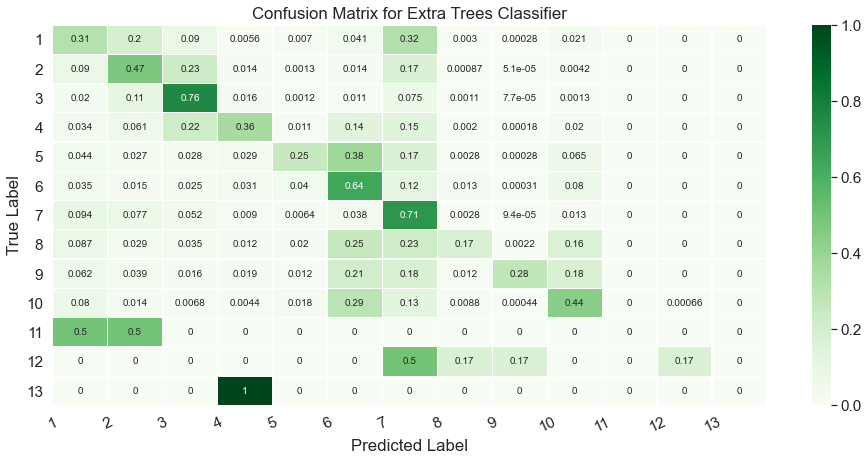

In [44]:
matrix = confusion_matrix(test_target, extra_trees_prediction)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

#plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
           cmap=plt.cm.Greens, linewidths=0.2)

#add labels to plot

class_names = [1,2,3,4,5,6,7,8,9,10,11,12,13] #all possible resultkeys

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5

plt.xticks(tick_marks, class_names, rotation = 25)
plt.yticks(tick_marks2, class_names, rotation = 0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.title('Confusion Matrix for Extra Trees Classifier')
plt.show()